### Estimating responses for decoding analyses

In [2]:
from poldracklab.fmri.spm_hrf import spm_hrf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 0, 'Time (secs)')

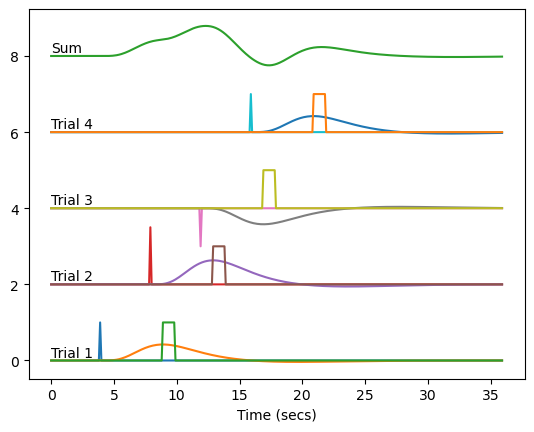

In [187]:
timestep = .1
tslength = 36

# stimulus every 4 seconds
onsets = np.arange(4, 20, 4).astype("int32")
intensities = np.array([1, 1.5, -1, 1])
neural_response = np.zeros(( int(tslength/timestep), len(onsets)))
hrf = np.zeros(neural_response.shape)
desmtx = np.zeros(neural_response.shape)
desmtx_conv = np.zeros(neural_response.shape)

timesteps = np.arange(0, tslength, timestep)
scaling = 20 

plot = 'add5'

# one column for each onset
for i, onset in enumerate(onsets):
    desmtx[int(onset//timestep), i] = 1
    desmtx_conv[:, i] = np.convolve(desmtx[:, i], spm_hrf(timestep))[:desmtx.shape[0]]
    plt.plot(timesteps, desmtx[:, i] * intensities[i] + i*2)
    plt.plot(timesteps, scaling * desmtx_conv[:, i] * intensities[i] + i*2)
    if plot == 'add5':
        ts = np.zeros(neural_response.shape[0])
        # fill onset + 2 seconds with zero
        first = int(onset//timestep)
        ts[int((onset + 5)//timestep):int((onset + 6)//timestep)] = 1
        plt.plot(timesteps, ts + i*2)

    plt.text(0, .1 + i*2, f'Trial {i + 1}')

y = desmtx_conv.dot(intensities)
plt.plot(timesteps, (i*2 + 2) + scaling * y)
plt.text(0, .1 + (i*2 + 2), 'Sum')

plt.xlabel('Time (secs)')

With no noise, we can deconvolve the signals.

In [180]:
print(int(onset//timestep):int((onset + 1)//timestep))

SyntaxError: invalid syntax (511733351.py, line 1)

Even with noise added, we can get unbiased estimates of the single-trial responses.

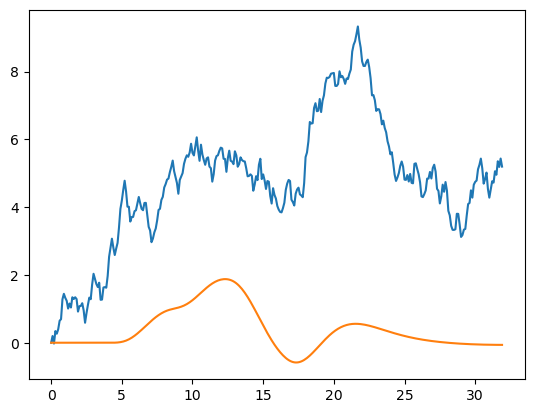

In [159]:

def get_desmtx(timestep=.1, tslength=32, onsets=None):
    if onsets is None:
        onsets = np.arange(4, 20, 4).astype("int32")
    # last one is intercept
    desmtx = np.zeros(( int(tslength/timestep), len(onsets) + 1))
    desmtx_conv = np.zeros(desmtx.shape)
    for i, onset in enumerate(onsets):
        desmtx[int(onset//timestep), i] = 1
        desmtx_conv[:, i] = np.convolve(desmtx[:, i], 
                                        spm_hrf(timestep))[:desmtx.shape[0]]
        # scale to max 1
        desmtx_conv[:, i] = desmtx_conv[:, i] / np.max(desmtx_conv[:, i])
    desmtx_conv[:, -1] = 1
    return desmtx_conv

# from chatgpt
def generate_ar1_noise(size, alpha=.999, sigma=1.0):
    """
    Generate AR(1) noise.
    
    Parameters:
        size (int): The length of the time series.
        alpha (float): The AR(1) coefficient (between 0 and 1 for positive correlation).
        sigma (float): The standard deviation of the white noise (default is 1.0).
    
    Returns:
        np.ndarray: The generated AR(1) noise.
    """
    # Generate white noise
    white_noise = np.random.normal(loc=0.0, scale=sigma, size=size)
    
    # Initialize the time series
    ar1_noise = np.zeros(size)
    
    # Generate AR(1) process
    for t in range(1, size):
        ar1_noise[t] = alpha * ar1_noise[t-1] + white_noise[t]
    
    return ar1_noise

def sim_data(desmtx_conv, intensities=None, noise_sd=1):
    if intensities is None:
        intensities = np.array([1, 1.5, -1, 1, 0])
    y = desmtx_conv.dot(intensities) + generate_ar1_noise(desmtx_conv.shape[0], sigma=noise_sd)
    return y

timestep = .1
tslength = 32
desmtx = get_desmtx(timestep, tslength)
timesteps = np.arange(0, tslength, timestep)

plt.plot(timesteps, sim_data(desmtx, noise_sd=.25))
intensities = np.array([1, 1.5, -1, 1, 0])
plt.plot(timesteps, desmtx.dot(intensities))



In [160]:
nsims = 10000
noise_sd = .25
timestep = .1
tslength = 32

beta_est = []
corrs = []
X = get_desmtx(timestep, tslength)
for i in range(nsims):
    y = sim_data(X, noise_sd=noise_sd)
    beta_est.append(np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y))
    corrs.append(np.corrcoef(beta_est[-1], intensities)[0,1])
    
beta_est = np.array(beta_est)


In [161]:
mean_betas = beta_est.mean(axis=0)
print(mean_betas)
np.corrcoef(mean_betas, intensities)[0,1]

[ 0.97383074  1.508447   -0.99880308  1.02260068  0.036992  ]


np.float64(0.9997207894332022)

Text(0.5, 0, 'Corr(true, estimated) betas')

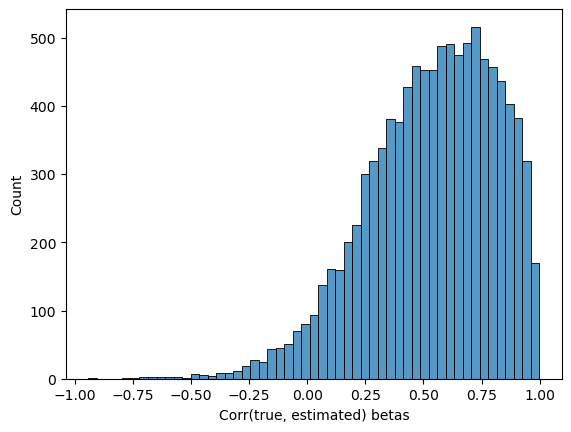

In [162]:
sns.histplot(corrs)
plt.xlabel('Corr(true, estimated) betas')

Text(0.5, 0, 'Predictors')

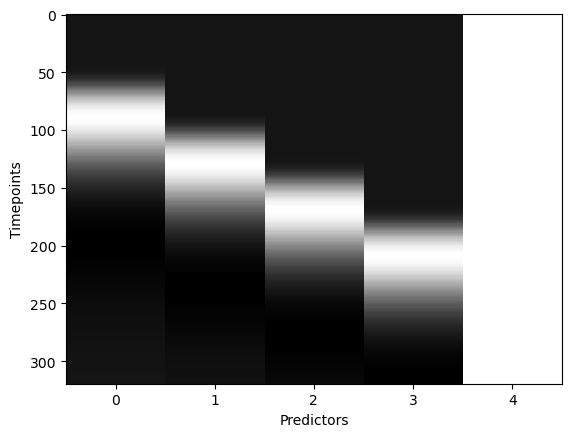

In [157]:
plt.imshow(X, aspect='auto', cmap='gray', interpolation='nearest')
plt.ylabel('Timepoints')
plt.xlabel('Predictors')

In [11]:
np.arange(20, 140, 40)

array([ 20,  60, 100])

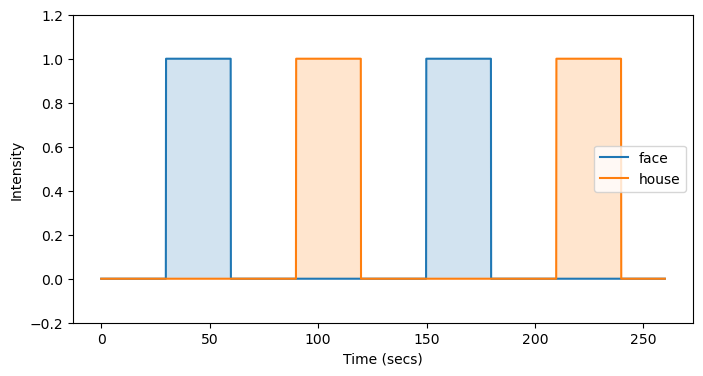

In [50]:
# blocked design - 2 condition example

timestep = .1
tslength = 260
timesteps = np.arange(0, tslength, timestep)
blocklength = 30


# stimulus every 4 seconds
desmtx = np.zeros((int(tslength/timestep), 2)).astype("int32")

onsets = np.vstack((np.arange(30, tslength, blocklength*4), 
                    np.arange(90, tslength, blocklength*4))).astype("int32").T
for i in range(onsets.shape[0]):
    for j in range(onsets.shape[1]):
        desmtx[int(onsets[i, j]//timestep):(int(onsets[i, j]//timestep + blocklength//timestep)), j]= 1

plt.figure(figsize=(8, 4))
plt.plot(timesteps, desmtx)
plt.legend(['face', 'house'])
plt.xlabel('Time (secs)')
plt.ylabel('Intensity')
plt.ylim(-0.2, 1.2)
for i in range(onsets.shape[0]):
    plt.fill_between(timesteps, 0, 1, where=desmtx[:, i] == 1, alpha=.2)

Text(0, 0.5, 'Intensity')

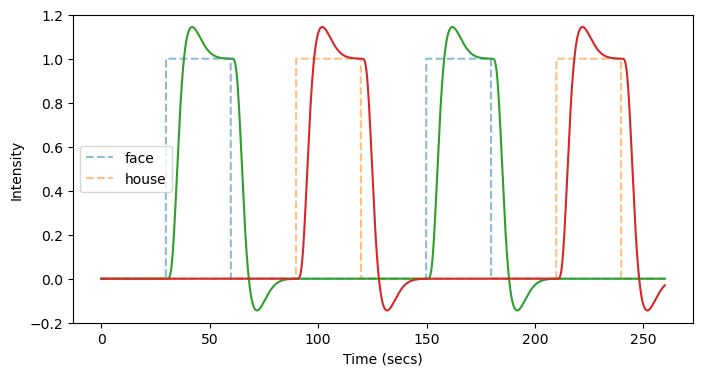

In [51]:
desmtx_conv = np.zeros(desmtx.shape)
for i in range(desmtx.shape[1]):
    desmtx_conv[:, i] = np.convolve(desmtx[:, i], spm_hrf(timestep))[:desmtx.shape[0]]


plt.figure(figsize=(8, 4))
plt.ylim(-0.2, 1.2)

plt.plot(timesteps, desmtx, '--', alpha=.5)
plt.plot(timesteps, desmtx_conv)
plt.legend(['face', 'house'])
plt.xlabel('Time (secs)')
plt.ylabel('Intensity')
# fill under the curve


Text(0, 0.5, 'Intensity')

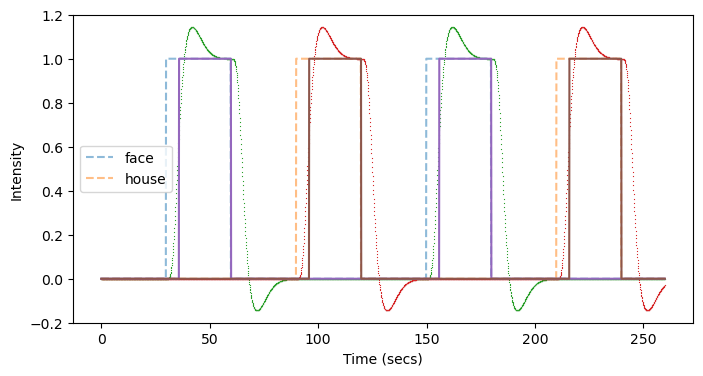

In [63]:
desmtx_trimmed = np.zeros((int(tslength/timestep), 2)).astype("int32")

onsets_trimmed = np.vstack((np.arange(36, tslength, blocklength*4), 
                    np.arange(96, tslength, blocklength*4))).astype("int32").T
for i in range(onsets_trimmed.shape[0]):
    for j in range(onsets_trimmed.shape[1]):
        desmtx_trimmed[int(onsets_trimmed[i, j]//timestep):(int(onsets_trimmed[i, j]//timestep + blocklength//timestep - 6//timestep)), j]= 1


plt.figure(figsize=(8, 4))
plt.ylim(-0.2, 1.2)

plt.plot(timesteps, desmtx, '--', alpha=.5)
plt.plot(timesteps, desmtx_conv, '*', markersize=.3)
plt.plot(timesteps, desmtx_trimmed)

plt.legend(['face', 'house'])
plt.xlabel('Time (secs)')
plt.ylabel('Intensity')
# fill under the curve

In [ ]:

desmtx 
intensities = np.array([1, 1.5, -1, 1])
neural_response = np.zeros(( int(tslength/timestep), len(onsets)))
hrf = np.zeros(neural_response.shape)
desmtx = np.zeros(neural_response.shape)
desmtx_conv = np.zeros(neural_response.shape)

timesteps = np.arange(0, tslength, timestep)
scaling = 20 

plot = 'add5'

# one column for each onset
for i, onset in enumerate(onsets):
    desmtx[int(onset//timestep), i] = 1
    desmtx_conv[:, i] = np.convolve(desmtx[:, i], spm_hrf(timestep))[:desmtx.shape[0]]
    plt.plot(timesteps, desmtx[:, i] * intensities[i] + i*2)
    plt.plot(timesteps, scaling * desmtx_conv[:, i] * intensities[i] + i*2)
    if plot == 'add5':
        ts = np.zeros(neural_response.shape[0])
        # fill onset + 2 seconds with zero
        first = int(onset//timestep)
        ts[int((onset + 5)//timestep):int((onset + 6)//timestep)] = 1
        plt.plot(timesteps, ts + i*2)

    plt.text(0, .1 + i*2, f'Trial {i + 1}')

y = desmtx_conv.dot(intensities)
plt.plot(timesteps, (i*2 + 2) + scaling * y)
plt.text(0, .1 + (i*2 + 2), 'Sum')

plt.xlabel('Time (secs)')